# GANs - MNIST (tensorflow)

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print('TensorFlow Version: {}'.format(tf.__version__))

Found GPU at: /device:GPU:0
TensorFlow Version: 1.12.0


In [0]:
# A bunch of utility functions

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


def show_images(images, img_rows=28, img_cols=28):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape(img_rows, img_cols))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

## Downloading dataset

In [3]:
def load_mnist_data(dim):
    from keras.datasets import mnist
    from keras import backend as K
    from keras.utils import to_categorical
    img_rows = 28
    img_cols = 28
    num_classes = 10
    
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    print(len(X_train), 'train samples')
    print(len(X_test), 'test samples')
    
    if dim == 3:
        if K.image_data_format() == 'channels_first':
            X_train = X_train.reshape(len(X_train), 1, img_rows, img_cols)
            X_test = X_test.reshape(len(X_test), 1, img_rows, img_cols)
        else:
            X_train = X_train.reshape(len(X_train), img_rows, img_cols, 1)
            X_test = X_test.reshape(len(X_test), img_rows, img_cols, 1)
    elif dim == 1:
        X_train = X_train.reshape(len(X_train), -1)
        X_test = X_test.reshape(len(X_test), -1)

    X_train = X_train.astype('float32') / 255.
    X_test = X_test.astype('float32') / 255.
    print('X_train shape:', X_train.shape)
    print('X_test shape:', X_test.shape)

    # convert class vectors to binary class matrices
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)
    return (X_train, y_train), (X_test, y_test)


(X_train, y_train), (X_test, y_test) = load_mnist_data(dim=1)

Using TensorFlow backend.


60000 train samples
10000 test samples
X_train shape: (60000, 784)
X_test shape: (10000, 784)


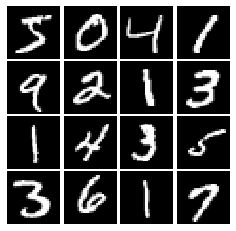

In [4]:
# show sample images
show_images(X_train[:16])

In [0]:
class dataset_batches():
    def __init__(self, X_train, shuffle=True):
        self.X_train = preprocess_img(X_train)
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        n = len(self.X_train)
        if self.shuffle:
            idx = np.arange(n)
            np.random.shuffle(idx)
            self.X_train = self.X_train[idx]
            
        n_batches = n // batch_size
        for i in range(0, n_batches * batch_size, batch_size):
            yield self.X_train[i:i+batch_size]

## Main

In [0]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    return tf.maximum(alpha*x, x)

def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    return tf.random_uniform((batch_size, dim), minval=-1, maxval=1)

def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate, beta1=beta1)
    return D_solver, G_solver

# a giant helper function
def run_a_gan(sess, X_train, G_sample,
              G_train_step, G_loss, D_train_step, D_loss,
              G_extra_step, D_extra_step,
              show_every=250, print_every=50, batch_size=128, epochs=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    it = 0
    for epoch in range(epochs):
        for minibatch in dataset_batches(X_train).batches(batch_size):
            
            # every show often, show a sample result
            if it % show_every == 0:
                samples = sess.run(G_sample)
                fig = show_images(samples[:16])
                plt.show()
            
            # run a batch of data through the network
            _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
            _, G_loss_curr = sess.run([G_train_step, G_loss])

            # print loss every so often.
            # We want to make sure D_loss doesn't go to 0
            if it % print_every == 0:
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(it, D_loss_curr, G_loss_curr))
                
            it += 1

    print('Final images')
    samples = sess.run(G_sample)
    fig = show_images(samples[:16])
    plt.show()

## Vanilla DCGAN

### Discriminator architecture:
- 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
- Max Pool 2x2, Stride 2
- 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
- Max Pool 2x2, Stride 2
- Flatten
- Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
- Fully Connected size 1

### Generator architecture:
- Fully connected of size 1024, ReLU
- BatchNorm
- Fully connected of size 7 x 7 x 128, ReLU
- BatchNorm
- Resize into Image Tensor
- 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
- BatchNorm
- 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [0]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        x_img = tf.reshape(x, [-1, 28, 28, 1])
        conv1 = tf.layers.conv2d(x_img, 32, 5, activation=leaky_relu, padding='valid')
        pool1 = tf.layers.max_pooling2d(conv1, 2, 2, padding='same')
        conv2 = tf.layers.conv2d(pool1, 64, 5, activation=leaky_relu, padding='valid')
        pool2 = tf.layers.max_pooling2d(conv2, 2, 2, padding='same')
        dims = int(np.prod(pool2.get_shape()[1:]))
        pool2_flat = tf.reshape(pool2, [-1, dims])
        fc1 = tf.layers.dense(pool2_flat, 1024, activation=leaky_relu)
        logits = tf.layers.dense(fc1, 1)
        return logits

def generator(z):
    with tf.variable_scope("generator"):
        fc1 = tf.layers.dense(z, 1024, activation=tf.nn.relu)
        bn1 = tf.layers.batch_normalization(fc1, training=True)
        fc2 = tf.layers.dense(bn1, 7*7*128, activation=tf.nn.relu)
        bn2 = tf.layers.batch_normalization(fc2, training=True)
        bn2_img = tf.reshape(bn2, [-1, 7, 7, 128])
        convT1 = tf.layers.conv2d_transpose(bn2_img, 64, 4, strides=2, activation=tf.nn.relu, padding='same')
        bn3 = tf.layers.batch_normalization(convT1, training=True)
        convT2 = tf.layers.conv2d_transpose(bn3, 1, 4, strides=2, padding='same')
        img = tf.tanh(convT2)
        img = tf.reshape(img, [-1, 784])
        return img

def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    D_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(logits_real)))
    D_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.zeros_like(logits_fake)))
    D_loss = D_loss_real + D_loss_fake
    G_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.ones_like(logits_fake)))
    return D_loss, G_loss

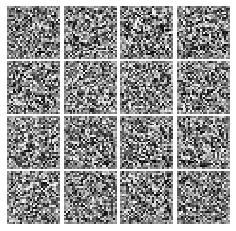

Iter: 0, D: 1.381, G:0.7742
Iter: 50, D: 0.6897, G:1.737
Iter: 100, D: 0.9724, G:1.058
Iter: 150, D: 1.464, G:0.9847
Iter: 200, D: 1.025, G:1.011


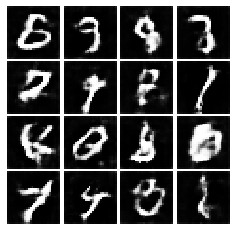

Iter: 250, D: 1.08, G:0.8975
Iter: 300, D: 1.213, G:0.6297
Iter: 350, D: 1.13, G:0.7777
Iter: 400, D: 1.109, G:1.01
Iter: 450, D: 1.184, G:0.8618


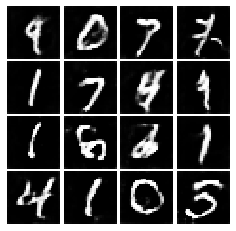

Iter: 500, D: 1.262, G:1.236
Iter: 550, D: 1.15, G:1.178
Iter: 600, D: 1.132, G:0.9368
Iter: 650, D: 1.378, G:0.584
Iter: 700, D: 1.148, G:1.084


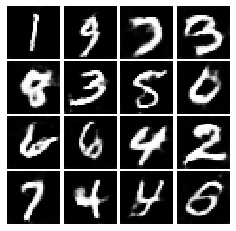

Iter: 750, D: 1.171, G:1.046
Iter: 800, D: 1.229, G:0.7277
Iter: 850, D: 1.098, G:1.015
Iter: 900, D: 1.175, G:0.8451
Iter: 950, D: 1.173, G:0.83


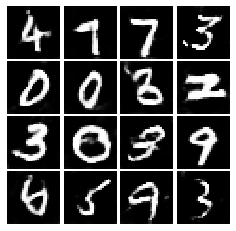

Iter: 1000, D: 1.12, G:1.052
Iter: 1050, D: 1.052, G:1.024
Iter: 1100, D: 1.211, G:1.154
Iter: 1150, D: 1.152, G:1.184
Iter: 1200, D: 1.249, G:0.4124


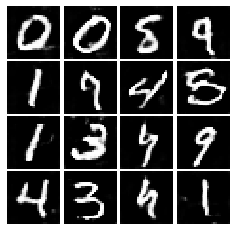

Iter: 1250, D: 1.152, G:0.8808
Iter: 1300, D: 1.208, G:1.655
Iter: 1350, D: 1.109, G:1.054
Iter: 1400, D: 1.151, G:1.222
Iter: 1450, D: 1.208, G:1.311


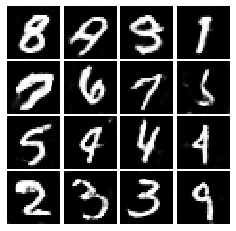

Iter: 1500, D: 1.074, G:0.8049
Iter: 1550, D: 1.157, G:0.9059
Iter: 1600, D: 1.326, G:1.74
Iter: 1650, D: 1.087, G:0.7844
Iter: 1700, D: 1.221, G:1.186


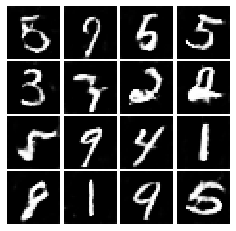

Iter: 1750, D: 1.124, G:0.844
Iter: 1800, D: 1.147, G:0.9242
Iter: 1850, D: 1.228, G:1.309
Iter: 1900, D: 0.9973, G:0.9431
Iter: 1950, D: 1.121, G:0.9909


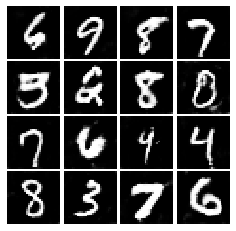

Iter: 2000, D: 1.157, G:1.668
Iter: 2050, D: 1.151, G:1.494
Iter: 2100, D: 1.08, G:0.9521
Iter: 2150, D: 1.264, G:0.9245
Iter: 2200, D: 1.062, G:0.9137


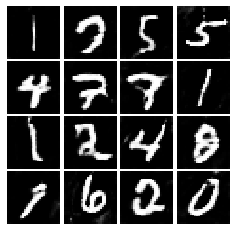

Iter: 2250, D: 1.063, G:1.241
Iter: 2300, D: 1.041, G:0.9131
Final images


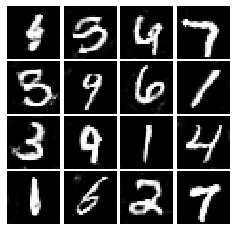

In [8]:
tf.reset_default_graph()

batch_size = 128
epochs = 5
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(x)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')

D_solver, G_solver = get_solvers()

D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')


with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, X_train, G_sample,
              G_train_step, G_loss, D_train_step, D_loss,
              G_extra_step, D_extra_step,
              batch_size=batch_size, epochs=epochs)

## DCGAN with LSGAN loss

In [0]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    D_loss_real = 0.5 * tf.reduce_mean((score_real - 1)**2)
    D_loss_fake = 0.5 * tf.reduce_mean(score_fake**2)
    D_loss = D_loss_real + D_loss_fake
    G_loss = 0.5 * tf.reduce_mean((score_fake - 1)**2)
    return D_loss, G_loss

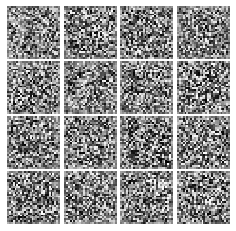

Iter: 0, D: 0.6431, G:0.1822
Iter: 50, D: 0.1955, G:0.02091
Iter: 100, D: 0.1674, G:0.1983
Iter: 150, D: 0.2306, G:0.1046
Iter: 200, D: 0.1842, G:0.1521


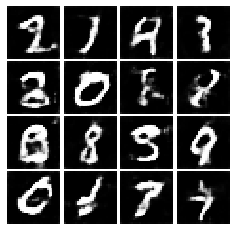

Iter: 250, D: 0.1983, G:0.08594
Iter: 300, D: 0.1777, G:0.2301
Iter: 350, D: 0.2026, G:0.1799
Iter: 400, D: 0.1881, G:0.2143
Iter: 450, D: 0.2036, G:0.173


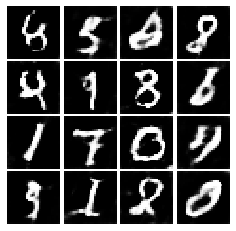

Iter: 500, D: 0.2456, G:0.09281
Iter: 550, D: 0.1827, G:0.1853
Iter: 600, D: 0.1997, G:0.1544
Iter: 650, D: 0.1809, G:0.2414
Iter: 700, D: 0.1938, G:0.1905


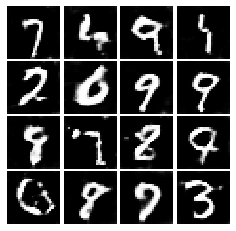

Iter: 750, D: 0.2044, G:0.3354
Iter: 800, D: 0.2006, G:0.1721
Iter: 850, D: 0.2426, G:0.1395
Iter: 900, D: 0.1945, G:0.1913
Iter: 950, D: 0.1791, G:0.1899


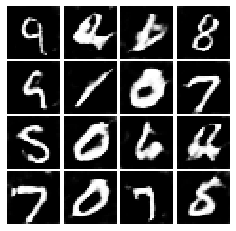

Iter: 1000, D: 0.1987, G:0.1837
Iter: 1050, D: 0.1896, G:0.1808
Iter: 1100, D: 0.1801, G:0.2611
Iter: 1150, D: 0.1875, G:0.3027
Iter: 1200, D: 0.1948, G:0.2314


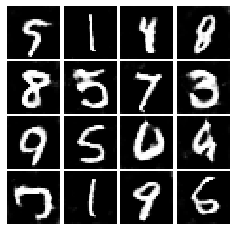

Iter: 1250, D: 0.1957, G:0.2181
Iter: 1300, D: 0.1985, G:0.1921
Iter: 1350, D: 0.1839, G:0.1842
Iter: 1400, D: 0.1798, G:0.2938
Iter: 1450, D: 0.28, G:0.2263


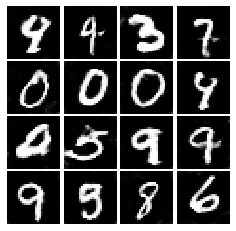

Iter: 1500, D: 0.188, G:0.192
Iter: 1550, D: 0.1789, G:0.2098
Iter: 1600, D: 0.1904, G:0.1593
Iter: 1650, D: 0.1731, G:0.1864
Iter: 1700, D: 0.189, G:0.2229


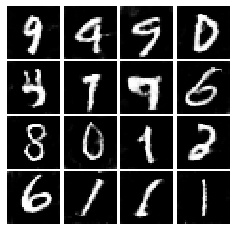

Iter: 1750, D: 0.1947, G:0.1735
Iter: 1800, D: 0.1763, G:0.1824
Iter: 1850, D: 0.1838, G:0.1685
Iter: 1900, D: 0.1604, G:0.2604
Iter: 1950, D: 0.1807, G:0.2698


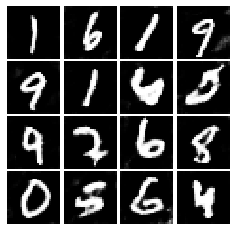

Iter: 2000, D: 0.1753, G:0.2367
Iter: 2050, D: 0.1897, G:0.1738
Iter: 2100, D: 0.166, G:0.2144
Iter: 2150, D: 0.1636, G:0.2121
Iter: 2200, D: 0.1778, G:0.24


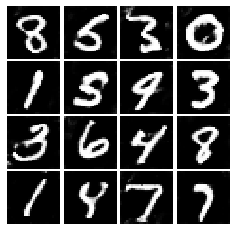

Iter: 2250, D: 0.1778, G:0.1996
Iter: 2300, D: 0.1842, G:0.2204
Final images


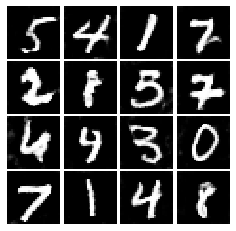

In [33]:
tf.reset_default_graph()

batch_size = 128
epochs = 5
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(x)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')


with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, X_train, G_sample,
              G_train_step, G_loss, D_train_step, D_loss,
              G_extra_step, D_extra_step,
              batch_size=batch_size, epochs=epochs)

## WGAN-GP

### Discriminator architecture:
- 64 Filters of 4x4, stride 2, LeakyReLU
- 128 Filters of 4x4, stride 2, LeakyReLU
- BatchNorm
- Flatten
- Fully connected 1024, LeakyReLU
- Fully connected size 1

### Generator architecture:
- Fully connected of size 1024, ReLU
- BatchNorm
- Fully connected of size 7 x 7 x 128, ReLU
- BatchNorm
- Resize into Image Tensor
- 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
- BatchNorm
- 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [0]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        x_img = tf.reshape(x, [-1,28,28,1])
        conv1 = tf.layers.conv2d(x_img, 64, 4, strides=2, activation=leaky_relu, padding='valid')
        conv2 = tf.layers.conv2d(conv1, 128, 4, strides=2, activation=leaky_relu, padding='valid')
        bn1 = tf.layers.batch_normalization(conv2, training=True)
        dims = int(np.prod(bn1.get_shape()[1:]))
        bn1_flat = tf.reshape(bn1, [-1,dims])
        fc1 = tf.layers.dense(bn1_flat, 1024, activation=leaky_relu)
        logits = tf.layers.dense(fc1, 1)
        return logits

def generator(z):
    with tf.variable_scope("generator"):
        fc1 = tf.layers.dense(z, 1024, activation=tf.nn.relu)
        bn1 = tf.layers.batch_normalization(fc1, training=True)
        fc2 = tf.layers.dense(bn1, 7*7*128, activation=tf.nn.relu)
        bn2 = tf.layers.batch_normalization(fc2, training=True)
        bn2_img = tf.reshape(bn2, [-1, 7, 7, 128])
        convT1 = tf.layers.conv2d_transpose(bn2_img, 64, 4, strides=2, activation=tf.nn.relu, padding='same')
        bn3 = tf.layers.batch_normalization(convT1, training=True)
        convT2 = tf.layers.conv2d_transpose(bn3, 1, 4, strides=2, padding='same')
        img = tf.tanh(convT2)
        img = tf.reshape(img, [-1, 784])
        return img

def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    D_loss = tf.reduce_mean(logits_fake - logits_real)
    G_loss = -tf.reduce_mean(logits_fake)

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform([batch_size, 1], minval=0., maxval=1.)
    x_hat = eps * x + (1 - eps) * G_sample

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = tf.gradients(discriminator(x_hat), x_hat)[0]

    grad_norm = tf.norm(grad_D_x_hat, axis=1)
    grad_pen = lam * tf.reduce_mean((grad_norm - 1)**2)

    D_loss += grad_pen

    return D_loss, G_loss

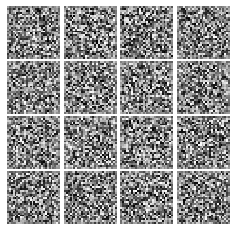

Iter: 0, D: 13.69, G:0.3951
Iter: 50, D: -2.261, G:-3.799
Iter: 100, D: -2.25, G:-0.2321
Iter: 150, D: 9.904, G:1.128
Iter: 200, D: -1.192, G:-2.653


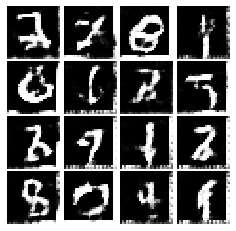

Iter: 250, D: -3.507, G:-2.367
Iter: 300, D: 0.09997, G:-2.302
Iter: 350, D: 0.3216, G:0.1304
Iter: 400, D: 0.5642, G:-0.4319
Iter: 450, D: -0.1732, G:-1.279


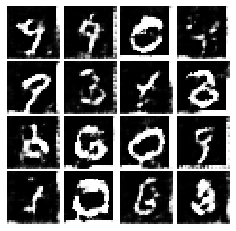

Iter: 500, D: 0.3995, G:-2.27
Iter: 550, D: -0.5811, G:-1.363
Iter: 600, D: -0.6483, G:-2.545
Iter: 650, D: -1.482, G:-2.989
Iter: 700, D: -2.13, G:-1.135


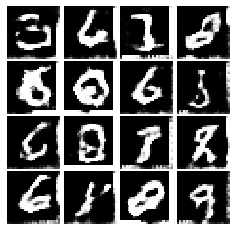

Iter: 750, D: -2.909, G:-5.174
Iter: 800, D: -2.368, G:-3.318
Iter: 850, D: -1.574, G:-5.833
Iter: 900, D: -2.123, G:-8.152
Iter: 950, D: -2.456, G:-11.44


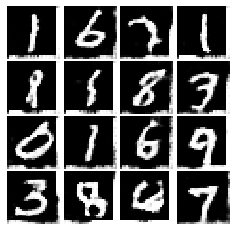

Iter: 1000, D: -1.339, G:2.377
Iter: 1050, D: -2.657, G:-0.1522
Iter: 1100, D: -0.4391, G:-13.32
Iter: 1150, D: -2.803, G:-2.477
Iter: 1200, D: -1.663, G:-5.621


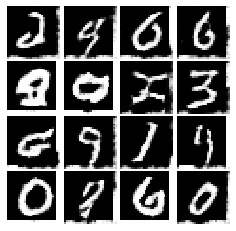

Iter: 1250, D: -2.636, G:-12.02
Iter: 1300, D: -2.356, G:-5.944
Iter: 1350, D: 0.97, G:0.8151
Iter: 1400, D: 0.1507, G:-2.692
Iter: 1450, D: 0.3001, G:-2.04


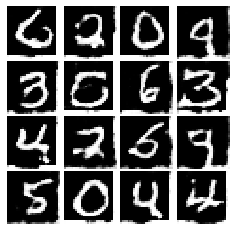

Iter: 1500, D: 0.1849, G:0.8306
Iter: 1550, D: 0.2256, G:0.01828
Iter: 1600, D: -0.2703, G:-0.4919
Iter: 1650, D: 0.08178, G:-1.97
Iter: 1700, D: 0.1272, G:-1.835


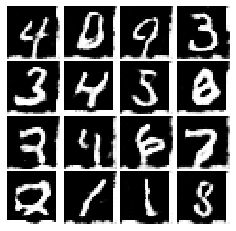

Iter: 1750, D: -0.4744, G:-1.454
Iter: 1800, D: 0.2792, G:-1.795
Iter: 1850, D: -0.2771, G:-3.039
Iter: 1900, D: -0.01993, G:-0.5708
Iter: 1950, D: -0.1591, G:0.6731


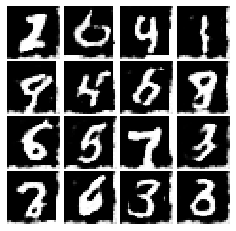

Iter: 2000, D: -0.1323, G:-2.372
Iter: 2050, D: 0.2944, G:-3.661
Iter: 2100, D: -0.2879, G:-2.374
Iter: 2150, D: 0.06152, G:0.2023
Iter: 2200, D: -0.373, G:-6.557


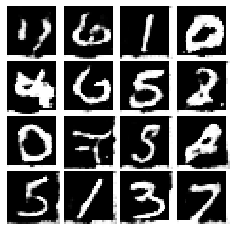

Iter: 2250, D: -0.03694, G:-0.332
Iter: 2300, D: 0.1486, G:-2.809
Final images


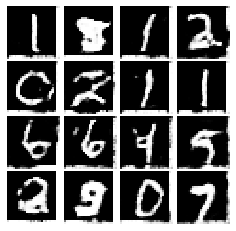

In [43]:
tf.reset_default_graph()

batch_size = 128
epochs = 5
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(x)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')


with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, X_train, G_sample,
              G_train_step, G_loss, D_train_step, D_loss,
              G_extra_step, D_extra_step,
              batch_size=batch_size, epochs=epochs)